# Models and Evaluation

In [38]:
import pandas as pd
import numpy as np
from IPython.display import display

data = pd.read_csv('../assets/final/data.csv')

#display(data.head())

In [39]:
def get_features(df):
    return df.drop('paid', axis=1)
def get_target(df):
    return df.drop(df.columns.difference(['paid']), axis=1)

results = {}

### Split data

In [40]:
def split_data(features, target, test_size=0.25, random_state=1):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [41]:
print('Data shape:',data.shape)
print('paid  1:',data[data['paid']==1].shape)
print('paid -1:',data[data['paid']==-1].shape)

_X_train, _X_test, _y_train, _y_test = split_data(get_features(data), get_target(data))

print('\nTrain shape:',_y_train.shape)
print('paid ratio:',_y_train[_y_train['paid']==1].shape[0],'|',_y_train[_y_train['paid']==-1].shape[0])

print('\nTest shape:',_y_test.shape)
print('paid ration:',_y_test[_y_test['paid']==1].shape[0],'|',_y_test[_y_test['paid']==-1].shape[0])

Data shape: (291, 13)
paid  1: (253, 13)
paid -1: (0, 13)

Train shape: (218, 1)
paid ratio: 186 | 0

Test shape: (73, 1)
paid ration: 67 | 0


### Resampling

In [42]:
def oversample(X_train, y_train):
    from imblearn.over_sampling import SMOTE
    sm = SMOTE(random_state=1, sampling_strategy=1.0)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    return X_train, y_train

In [43]:
_smote_X_train, _smote_y_train = oversample(_X_train, _y_train)

print('\nTrain shape:',_smote_y_train.shape)
print('Paid ratio:',_smote_y_train[_smote_y_train['paid']==1].shape[0],'|',_smote_y_train[_smote_y_train['paid']==-1].shape[0])


Train shape: (372, 1)
Paid ratio: 186 | 0


### Scaling

In [44]:
def normalize_data(X_train, X_test, scaler):
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    return X_train, X_test

def standardize_data(X_train, X_test):
    from sklearn.preprocessing import StandardScaler
    return normalize_data(X_train, X_test, StandardScaler())

def min_max_scaling(X_train, X_test):
    from sklearn.preprocessing import MinMaxScaler
    return normalize_data(X_train, X_test, MinMaxScaler())

### Algorithms

In [45]:
def add_model(name, model, use_smote=False):
    import datetime
    X_train = _X_train.copy()
    X_test = _X_test.copy()
    smote_X_train = _smote_X_train.copy()
    """
    if (name == 'dtc'):
        X_train.drop(['age_on_loan_request_disc'], inplace=True, axis=1)
        X_test.drop(['age_on_loan_request_disc'], inplace=True, axis=1)
        smote_X_train.drop(['age_on_loan_request_disc'], inplace=True, axis=1)
    else:
        X_train.drop(['age_on_loan_request'], inplace=True, axis=1)
        X_test.drop(['age_on_loan_request'], inplace=True, axis=1)
        smote_X_train.drop(['age_on_loan_request'], inplace=True, axis=1)
    """ 
    # Scaling Normalizations
    # X_train, X_test = standardize_data(X_train, X_test)
    # X_train, X_test = min_max_scaling(X_train, X_test)

    start = datetime.datetime.now()
    if use_smote: model.fit(smote_X_train, np.ravel(_smote_y_train.values))
    else: model.fit(X_train, np.ravel(_y_train.values))
    end = datetime.datetime.now()
    
    results[name] = {'model': model, 
                    'X_train': X_train, 
                    'X_test': X_test, 
                    'y_train': np.ravel(_y_train.values), 
                    'y_test': np.ravel(_y_test.values),
                    'fit_time': (end - start).microseconds / 1000 # time difference in milliseconds
                    }

In [46]:
SMOTE = True

In [47]:
from sklearn.tree import DecisionTreeClassifier
add_model('dtc',
    DecisionTreeClassifier(),
    use_smote=SMOTE
)

In [48]:
from sklearn.neighbors import KNeighborsClassifier
add_model('knn',
    KNeighborsClassifier(),
    use_smote=SMOTE
)

In [49]:
from sklearn.neural_network import MLPClassifier
add_model('mlp',
    MLPClassifier(),
    use_smote=SMOTE
)

In [50]:
from sklearn.naive_bayes import GaussianNB
add_model('gnb',
    GaussianNB(),
    use_smote=SMOTE
)

In [51]:
from sklearn.svm import SVC
add_model('svc',
    SVC(probability=True),
    use_smote=SMOTE
)

In [52]:
from sklearn.ensemble import RandomForestClassifier
add_model('rf',
    RandomForestClassifier(),
    use_smote=SMOTE
)

### Randomized Search

In [53]:
SEARCH = False

In [54]:
def add_model_rs(name, model, space={}):
    import json
    from datetime import datetime
    from sklearn.model_selection import RandomizedSearchCV
    X = get_features(data)
    y = np.ravel(get_target(data).values)
    if (name == 'dtc'):
        X.drop(['age_on_loan_request_disc'], inplace=True, axis=1)
    else:
        X.drop(['age_on_loan_request'], inplace=True, axis=1)
        
    # Scaling Normalizations
    # X_train, X_test = standardize_data(X_train, X_test)
    # X_train, X_test = min_max_scaling(X_train, X_test)

    search = RandomizedSearchCV(model, space, n_iter=500, scoring='roc_auc', n_jobs=-1, random_state=0, cv=5)
    search.fit(X, y)
    results[name] = {# 'search': search.best_estimator_,
                    'best_params': search.best_params_,
                    'best_score': search.best_score_}
                    #'X': X,
                    #'y': y}
    with open('random_search_results/'+name+'_'+str(datetime.timestamp(datetime.now()))+'.json', 'w') as f:
        json.dump(results[name], f)

In [55]:
from sklearn.tree import DecisionTreeClassifier
if SEARCH:
    add_model_rs('dtc',
        DecisionTreeClassifier(),
        space={
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
            'min_samples_split': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
            'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
            'max_features': [None, 'auto', 'sqrt', 'log2'],
        }
    )

In [56]:
from sklearn.neighbors import KNeighborsClassifier
if SEARCH:
    add_model_rs('knn',
        KNeighborsClassifier(),
        space={
            'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
        }
    )

In [57]:
from sklearn.neural_network import MLPClassifier
if SEARCH:
    add_model_rs('mlp',
        MLPClassifier(),
        space={
            
        }
    )

In [58]:
from sklearn.naive_bayes import GaussianNB
if SEARCH:
    add_model_rs('gnb',
        GaussianNB(),
        space={
            
        }
    )

In [59]:
from sklearn.svm import SVC
if SEARCH:
    add_model_rs('svc',
        SVC(probability=True),
        space={
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'degree': [1, 2, 3, 5, 7, 10],
            'gamma': ['scale', 'auto'],
            'coef0': [0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
            'shrinking': [True, False],
            'probability': [True],
            'tol': [0.001, 0.0001, 0.00001],
            'class_weight': [None, 'balanced'],
            'decision_function_shape': ['ovo', 'ovr'],
            'max_iter': [100, 10000]
        }
    )

In [60]:
from sklearn.ensemble import RandomForestClassifier
if SEARCH:
    add_model_rs('rf',
        RandomForestClassifier(),
        space={
            'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
            'min_samples_split': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
            'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
            'max_features': [None, 'auto', 'sqrt', 'log2'],
            'bootstrap': [True, False],
            'oob_score': [False],
            'n_jobs': [-1],
            'random_state': [None],
            'verbose': [0],
            'warm_start': [False],
            'class_weight': [None, 'balanced'],
            'ccp_alpha': [0.0],
        }
    )

## Prediction

In [61]:
def predict(name, isTrain=False):
    prefix = 'train' if isTrain else 'test'
    result = results[name]
    pred = result['model'].predict(result['X_'+prefix])
    result[prefix+'pred'] = pred

for name in results.keys():
    predict(name)
for name in results.keys():
    predict(name, isTrain=True)

In [62]:
def predict_proba(name, isTrain=False):
    prefix = 'train' if isTrain else 'test'
    result = results[name]
    proba = result['model'].predict_proba(result['X_'+prefix])
    result[prefix+'pred_prob'] = proba

for name in results.keys():
    predict_proba(name)
for name in results.keys():
    predict_proba(name, isTrain=True)


## Evaluation

In [63]:
def recall(cm, i):
    return cm[i][i]/sum(cm[i]) if sum(cm[i]) > 0 else np.inf

def precision(cm, i):
    cmt = np.copy(cm).transpose()
    return cm[i][i]/sum(cmt[i]) if sum(cmt[i]) > 0 else np.inf

def f_measure(cm, i):
    p = precision(cm, i)*100
    r = recall(cm, i)*100
    return 2 * (p * r) / (p + r) if p != np.inf and r != np.inf and p + r > 0 else np.nan

In [64]:
from matplotlib.figure import Figure
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def conf_matrix(y_test, y_pred, name, prefix):
    cm =  confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=['True', 'False'])
    disp.plot()
    disp.ax_.set_title(name + ' ' + prefix)

### Execution time

In [65]:
def fit_time(name):
    result = results[name]
    print(name.upper()+':\t', result['fit_time'], 'ms')

print('Fit execution time')
for name in results.keys():
    fit_time(name)

Fit execution time
DTC:	 3.998 ms
KNN:	 2.0 ms
MLP:	 97.994 ms
GNB:	 3.003 ms
SVC:	 34.999 ms
RF:	 135.029 ms


### Accuracy

In [66]:
def score(name, isTrain=False):
    prefix = 'train' if isTrain else 'test'
    result = results[name]
    result[prefix+'score'] = result['model'].score(result['X_'+prefix], result['y_'+prefix])
    print(name.upper()+":\t", result[prefix+'score'])

print('\tAccuracy')
print("Test")
for name in results.keys():
    score(name)
print("\nTrain")
for name in results.keys():
    score(name, isTrain=True)

	Accuracy
Test
DTC:	 0.8767123287671232
KNN:	 0.5616438356164384
MLP:	 0.5068493150684932
GNB:	 0.6027397260273972
SVC:	 0.6575342465753424
RF:	 0.8767123287671232

Train
DTC:	 1.0
KNN:	 0.8348623853211009
MLP:	 0.536697247706422
GNB:	 0.7844036697247706
SVC:	 0.7247706422018348
RF:	 1.0


### Precision, Recall and F-measure

In [67]:
def evaluate(name, isTrain=False):
    prefix = 'train' if isTrain else 'test'
    result = results[name]
    cm =  confusion_matrix(result['y_'+prefix], result[prefix+'pred'])
    print(prefix, name.upper()+":", '\tRecall:',round(recall(cm, 0), 2), '\t Precision:',round(precision(cm, 0), 2), '\tF_Measure:',round(f_measure(cm, 0), 2))

print('Test')
for name in results.keys():
    evaluate(name)
print('\nTrain')
for name in results.keys():
    evaluate(name, isTrain=True)


Test
test DTC: 	Recall: 0.33 	 Precision: 0.29 	F_Measure: 30.77
test KNN: 	Recall: 0.33 	 Precision: 0.07 	F_Measure: 11.11
test MLP: 	Recall: 0.83 	 Precision: 0.12 	F_Measure: 21.74
test GNB: 	Recall: 0.5 	 Precision: 0.1 	F_Measure: 17.14
test SVC: 	Recall: 0.5 	 Precision: 0.12 	F_Measure: 19.35
test RF: 	Recall: 0.33 	 Precision: 0.29 	F_Measure: 30.77

Train
train DTC: 	Recall: 1.0 	 Precision: 1.0 	F_Measure: 100.0
train KNN: 	Recall: 1.0 	 Precision: 0.47 	F_Measure: 64.0
train MLP: 	Recall: 0.72 	 Precision: 0.2 	F_Measure: 31.29
train GNB: 	Recall: 0.78 	 Precision: 0.38 	F_Measure: 51.55
train SVC: 	Recall: 0.53 	 Precision: 0.27 	F_Measure: 36.17
train RF: 	Recall: 1.0 	 Precision: 1.0 	F_Measure: 100.0


### Confusion Matrix

ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of ticklabels (2).

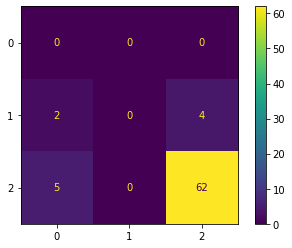

In [68]:
prob = 0.50

prefixes = ('test', 'train')
for prefix in prefixes[:1]:
    for name in results.keys():
        result = results[name]
        prefix = 'test'
        conf_matrix(result['y_'+prefix], np.where(result[prefix+'pred_prob'][:,-1] > prob, 1, -1), name, prefix)

### AUC

DTC test:	 0.6293532338308457
DTC train:	 1.0
KNN test:	 0.592039800995025
KNN train:	 0.9737903225806452
MLP test:	 0.7052238805970149
MLP train:	 0.7065692204301075
GNB test:	 0.5547263681592041
GNB train:	 0.8479502688172043
SVC test:	 0.6517412935323383
SVC train:	 0.699092741935484
RF test:	 0.7263681592039801
RF train:	 1.0


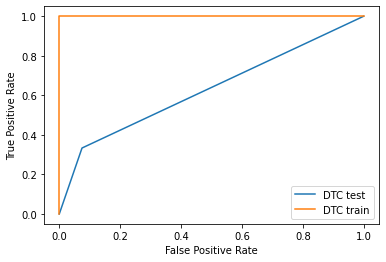

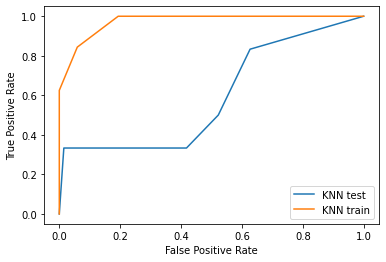

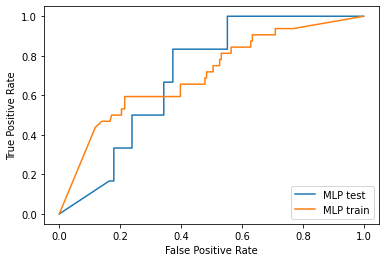

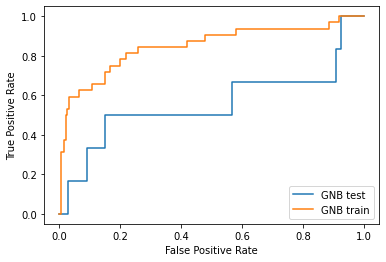

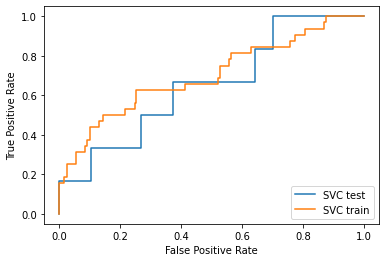

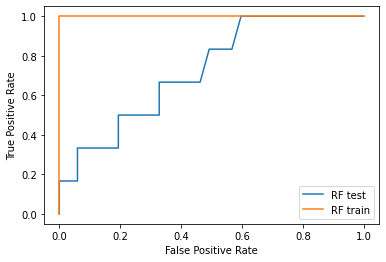

In [69]:
from sklearn.metrics import roc_curve, RocCurveDisplay, auc
import matplotlib.pyplot as plt

def roc_and_auc(name, isTrain=False):
    fig, ax = plt.subplots()
    for prefix in ('test', 'train'):
        result = results[name]
        fpr, tpr, thresholds = roc_curve(result['y_'+prefix], result[prefix+'pred_prob'][:,0], pos_label=result['model'].classes_[0])
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax,name=(name.upper()+' '+prefix))
        print(name.upper(), prefix + ":\t", auc(fpr, tpr))

for name in results.keys():
    roc_and_auc(name)